# Minneapolis: Police Complaints
## ETL and Analysis of Police Complaints
Details:
| Title           | Description                                                    |
|-----------------|----------------------------------------------------------------|
| Author          | Kymberly Ayodeji                                               |
| Start Date      | 2024-05-22                                                     |
| End Date        | 2024-05-23                                                          |
| Datasets        | Minneapolis OpenData: [Office Conduct](https://opendata.minneapolismn.gov/datasets/cityoflakes::officer-conduct-data/about)                                            |
| Products        |                                                                |
| Summary         |                                                                |

### 0: Install Libraries and Packages

In [27]:
# Import Packages and Libraries needed for the project
import pandas as pd
import numpy as np

# for data processing
import requests
import json

# for Geospatial data
import geopandas as gpd 

# for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [28]:
def a_load_data(url):
    # Load GeoPandas data from OpenData.Minneapolis.Gov API
    response = requests.get(url)
    data = json.loads(response.text)
    # since the data contains nested dictionaries we need to flatten the data from the outer features key
    data2 = pd.json_normalize(data['features'])
    # Rename the nested dictionary keys of geometry and  properties columns by removing geometry and properties.
    data2.columns = data2.columns.str.replace('geometry.', '')
    data2.columns = data2.columns.str.replace('properties.', '')
    return data2

In [29]:
# Office Conduct Data from Opendata.Minneapolis.Gov 
url="https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Officer_Conduct_Data/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
raw_data = a_load_data(url)
raw_data.head()

,type,id,geometry,Matter_Number,Short_Matter_Name,Law_Type_Description,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged,ObjectId
0,Feature,1,None,01L-0003,"Gatlin, Juwan - Estate v. City of Minneapolis",Officer Conduct,Officer Conduct,Hennepin County District Court,LITIGATION,Lawsuit Settlement,902466000000,1138946400000,1.172556e+12,1181192400000,"40,000",1
1,Feature,2,None,02L-0218,"Scott, Timothy v. City of Minneapolis",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,890287200000,1138946400000,1.142921e+12,1139464800000,"5,000",2
2,Feature,3,None,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1000184400000,1138946400000,1.146719e+12,1137045600000,"49,900",3
3,Feature,4,None,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1000184400000,1138946400000,1.146719e+12,1140674400000,"150,000",4
4,Feature,5,None,03L-0319,"Ngo, Duy v. City of Minneapolis",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1046152800000,1138946400000,1.198130e+12,1196402400000,"4,500,000",5


In [30]:
raw_data.isna().sum()

type                          0
id                            0
geometry                    274
Matter_Number                 0
Short_Matter_Name             0
Law_Type_Description          0
Matter_Type_Description       0
Jurisdiction_Description      0
Civil_Process                 0
DESCRIPTION                   0
Incident_Date                 0
Date_Opened                   0
Date_Closed                  24
Transaction_Date              0
Amount_Charged                0
ObjectId                      0
dtype: int64

In [31]:
def b_clean_data(df):
    # convert unix time to datetime
    date_cols = ['Incident_Date','Date_Opened', 'Date_Closed', 'Transaction_Date']
    for col in date_cols:
        raw_data[col] = pd.to_datetime(raw_data[col], unit='ms')

    # Drop columns that are not needed as they all have the same value
    cols_not_needed = ['id','geometry', 'type', 'Law_Type_Description', 'ObjectId']
    
    df.drop(columns=cols_not_needed, inplace=True, axis=1)
    
    
    # Convert object columns to numeric
    # remove commas from column
    df['Amount_Charged'] = df['Amount_Charged'].str.replace(',', '')
    df['Amount_Charged'] = df['Amount_Charged'].astype('float64')
    
    return df.reset_index(drop=True)

In [32]:
df = b_clean_data(raw_data)
df.head()

,Matter_Number,Short_Matter_Name,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged
0,01L-0003,"Gatlin, Juwan - Estate v. City of Minneapolis",Officer Conduct,Hennepin County District Court,LITIGATION,Lawsuit Settlement,1998-08-07 05:00:00,2006-02-03 06:00:00,2007-02-27 06:00:00,2007-06-07 05:00:00,40000.0
1,02L-0218,"Scott, Timothy v. City of Minneapolis",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1998-03-19 06:00:00,2006-02-03 06:00:00,2006-03-21 06:00:00,2006-02-09 06:00:00,5000.0
2,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2001-09-11 05:00:00,2006-02-03 06:00:00,2006-05-04 05:00:00,2006-01-12 06:00:00,49900.0
3,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2001-09-11 05:00:00,2006-02-03 06:00:00,2006-05-04 05:00:00,2006-02-23 06:00:00,150000.0
4,03L-0319,"Ngo, Duy v. City of Minneapolis",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2003-02-25 06:00:00,2006-02-03 06:00:00,2007-12-20 06:00:00,2007-11-30 06:00:00,4500000.0


In [33]:
def c_feature_engineering(df):
    
    # Extract Officer Name from the Short_Matter_Name column
    df['Plaintiff_Name'] = df['Short_Matter_Name'].str.split(' v.').str[0]
    
    # Create a new column called 'Case+Duration' to calculate the number of days it took to close a case
    df['Case_Duration'] = (df['Date_Closed'] - df['Date_Opened']).dt.days
    
    # Create a new column called 'Duration' to calculate the number of days it took to close a case from the Incident_Date column
    df['Duration'] = (df['Date_Closed'] - df['Incident_Date']).dt.days
    
    # Create a new column called 'Case_Year' to extract the year from the Date_Opened column
    df['Case_Year'] = df['Date_Opened'].dt.year
    
    # Create a new column called 'Incident_Year' to extract the year from the Date_Opened column
    df['Incident_Year'] = df['Incident_Date'].dt.year
    
    return df

In [34]:
df = c_feature_engineering(df)
df.shape

(274, 16)

In [35]:
def d_eda(df):
    # Object columns
    c_cols = ['Civil_Process','DESCRIPTION']
    fig, axs = plt.subplots(1, len(c_cols), figsize=(10,10))
    for ax, col in zip(axs, c_cols):
        # Calculate the counts for each category in the column
        counts = df[col].value_counts()
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'Count of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout
    plt.show()
    
    
    # Plot the distribution of the Duration column
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Duration'], kde=True,)
    plt.title('Distribution of Duration')
    plt.show()
    
    # Plot the distribution of the Case Duration column
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Case_Duration'], kde=True,)
    plt.title('Distribution of Case Duration')
    plt.show()
    
    
    # bar_plots for the categorical columns
    bar_cols = ['Jurisdiction_Description','Matter_Type_Description','DESCRIPTION']
    for col in bar_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(x=col, data=df)
        plt.title(f'Countplot of {col}')
        plt.show()
    
    # Plot the distribution Years columns

    # Plot the distribution of the Case Year column
    plt.figure(figsize=(12, 6))
    case_year_counts = df['Case_Year'].value_counts().sort_index()
    sns.barplot(case_year_counts)
    plt.title('Distribution of Case Year')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot the distribution of the Case Year column
    plt.figure(figsize=(12, 6))
    incident_year_counts = df['Incident_Year'].value_counts().sort_index()
    sns.barplot(incident_year_counts)
    plt.title('Distribution of Incident Year')
    plt.xticks(rotation=45)
    plt.show()
    
    return None

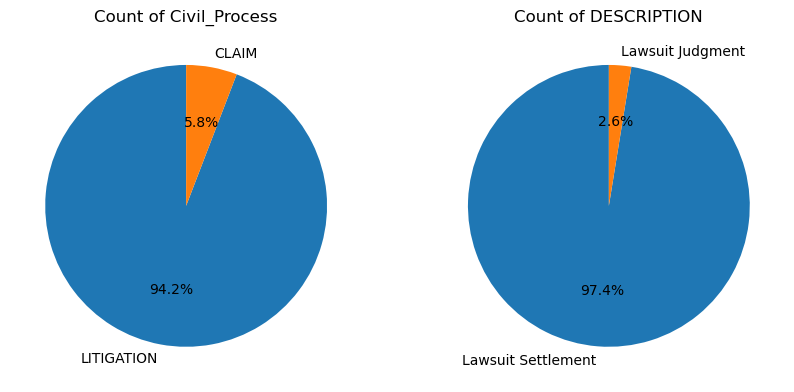

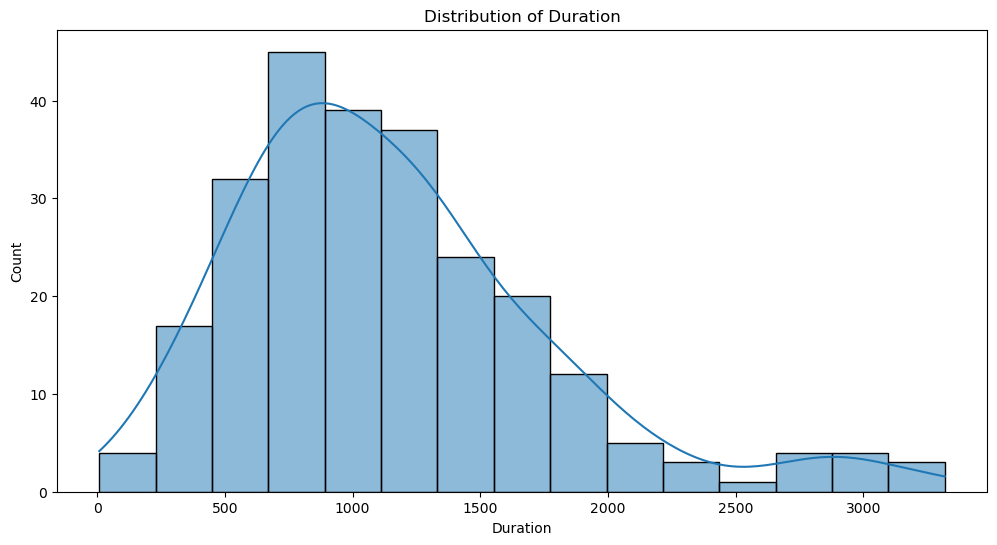

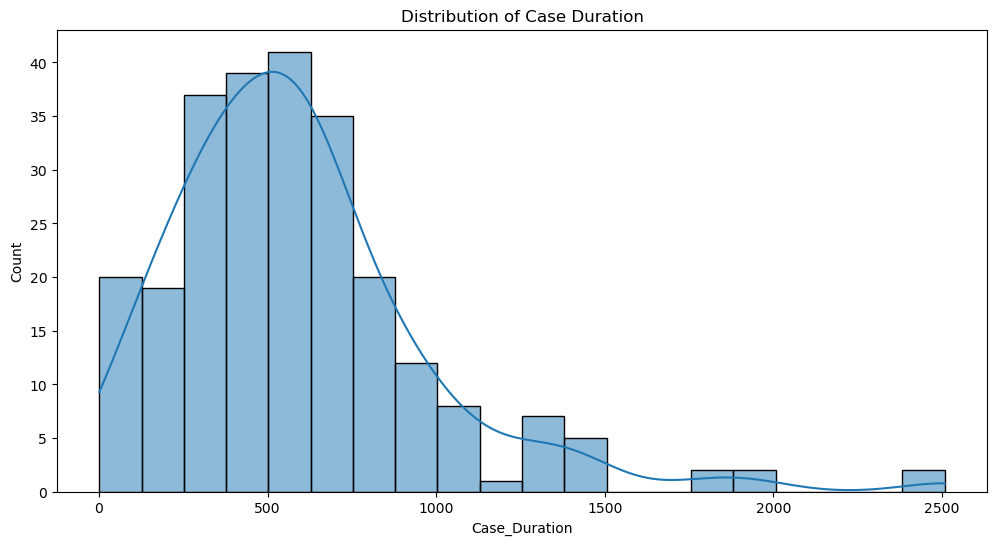

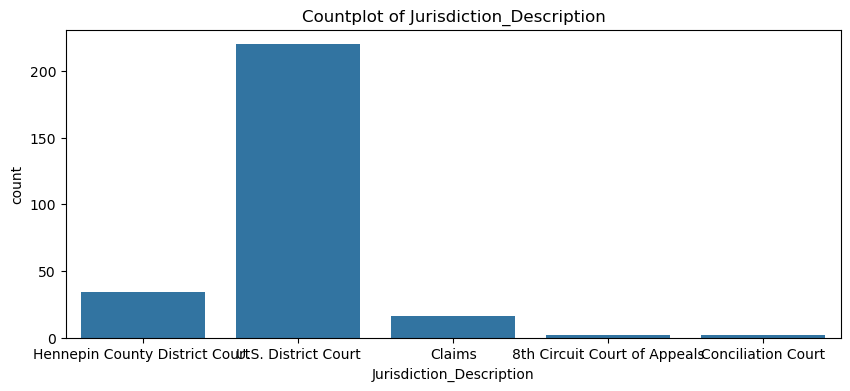

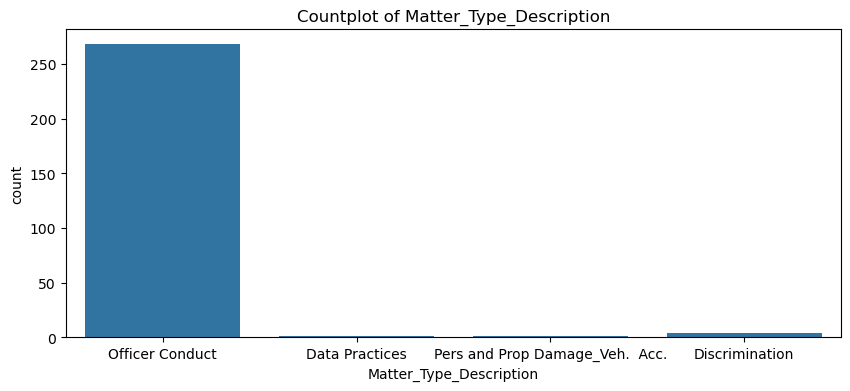

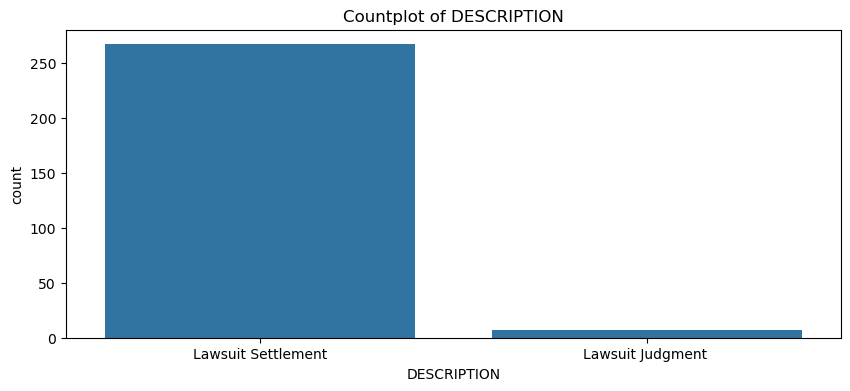

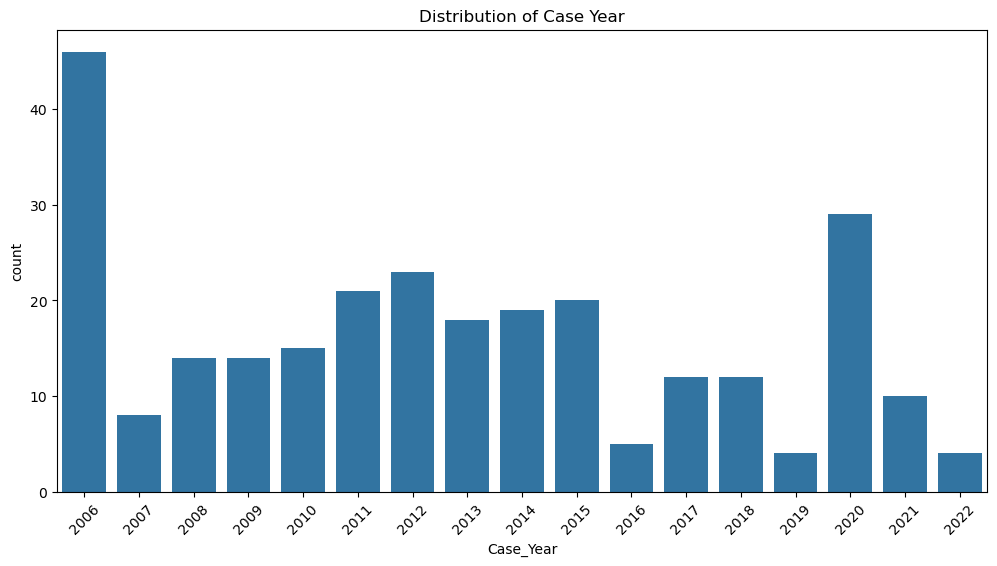

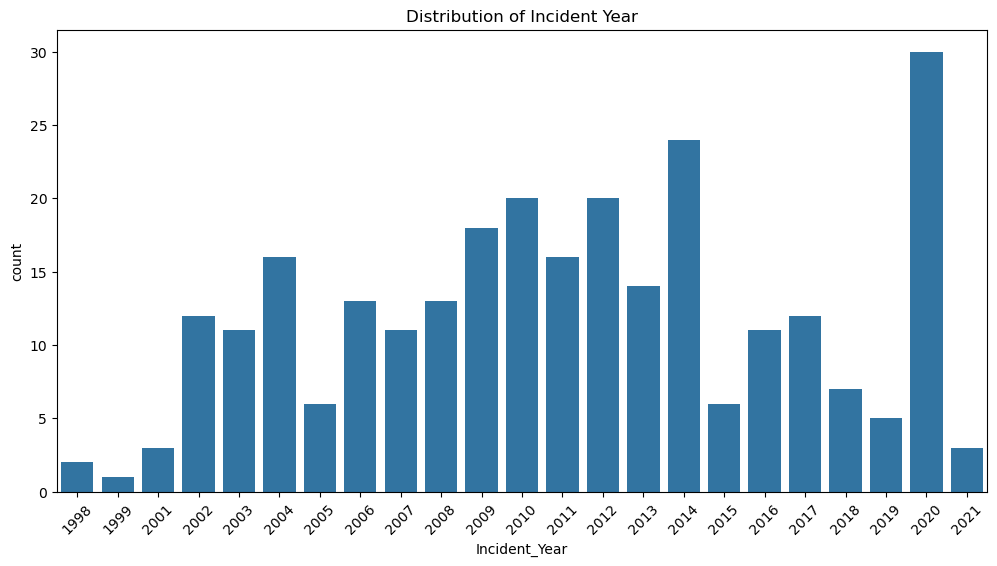

In [36]:
d_eda(df)

In [37]:
df['Plaintiff_Name'].value_counts().sort_values(ascending=False).head(12)

Plaintiff_Name
McWhorter, Bernadine (Trustee:Bragg Burns)    3
Lynch, Catrice                                2
Kastner, Nicholas                             2
Franklin, Walter                              2
Robinson, Darryl Maurice                      2
Labon, Malcolm                                2
Stepnes, Paul                                 2
Crowder, Tiffany                              2
Wuchko, John                                  2
Simpson, John Emmett                          2
Robinson, Zeanna                              2
Stallings, Jaleel Kevin                       2
Name: count, dtype: int64

In [38]:
df[df['Amount_Charged'] == df['Amount_Charged'].max()]

,Matter_Number,Short_Matter_Name,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged,Plaintiff_Name,Case_Duration,Duration,Case_Year,Incident_Year
146,20-06868,"Floyd, George (Schaffer v. Chauvin, et al.)",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2020-05-25 05:00:00,2020-05-26 05:00:00,NaT,2021-12-20 06:00:00,27000000.0,"Floyd, George (Schaffer",NaN,NaN,2020,2020


In [39]:
df[df['Date_Closed'].isnull()].sort_values(by='Incident_Date', ascending=False).head()

,Matter_Number,Short_Matter_Name,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged,Plaintiff_Name,Case_Duration,Duration,Case_Year,Incident_Year
183,21-09887,"Hernandez, Nicholas",Officer Conduct,Hennepin County District Court,LITIGATION,Lawsuit Settlement,2021-06-05 05:00:00,2021-10-25 05:00:00,NaT,2023-04-20 05:00:00,57500.0,"Hernandez, Nicholas",NaN,NaN,2021,2021
179,21-03046,"McKizzie, Damareion",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2021-03-23 05:00:00,2021-03-30 05:00:00,NaT,2022-07-19 05:00:00,50000.0,"McKizzie, Damareion",NaN,NaN,2021,2021
165,20-10290,"Samaha, Jamal",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2020-05-31 05:00:00,2020-08-11 05:00:00,NaT,2022-12-21 06:00:00,350000.0,"Samaha, Jamal",NaN,NaN,2020,2020
154,20-08601,"Stevenson, Soren v. Bauer, et al.",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Judgment,2020-05-31 05:00:00,2020-06-23 05:00:00,NaT,2022-12-16 06:00:00,1494197.6,"Stevenson, Soren",NaN,NaN,2020,2020
186,21-10520,"Meyer, Scott H",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2020-05-31 05:00:00,2021-11-15 06:00:00,NaT,2022-12-21 06:00:00,75000.0,"Meyer, Scott H",NaN,NaN,2021,2020


In [40]:
df['Amount_Charged'].describe()

count    2.740000e+02
mean     3.346200e+05
std      2.104193e+06
min      1.500000e+02
25%      1.000000e+04
50%      2.900500e+04
75%      7.837500e+04
max      2.700000e+07
Name: Amount_Charged, dtype: float64

<Axes: ylabel='Amount_Charged'>

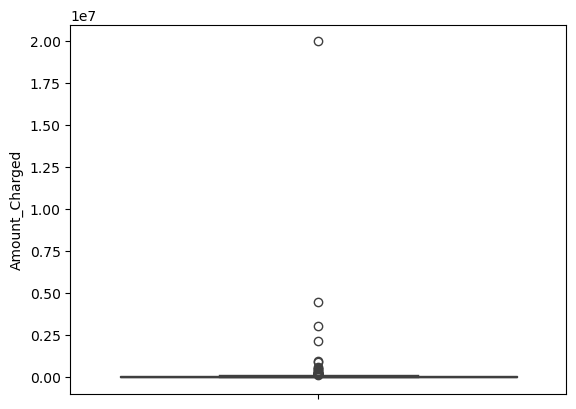

In [41]:
sns.boxplot(df[df['Date_Closed'].notnull()]['Amount_Charged'])

<Axes: xlabel='Amount_Charged', ylabel='Count'>

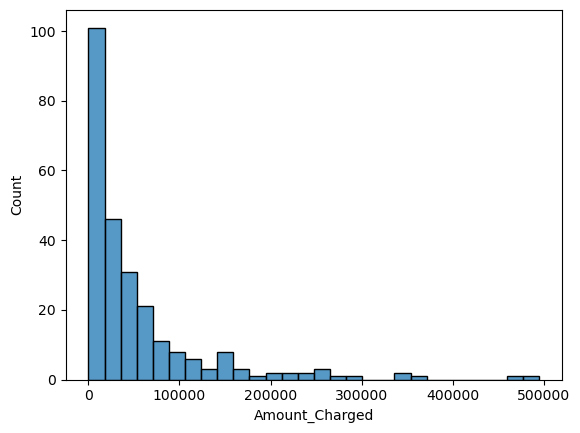

In [42]:
sns.histplot(df[df['Amount_Charged'] < 500000]['Amount_Charged'], kde=False)

<Axes: xlabel='Amount_Charged', ylabel='Count'>

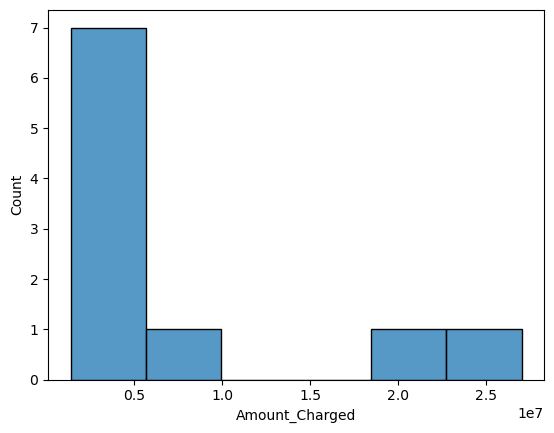

In [43]:
sns.histplot(df[df['Amount_Charged'] >1000000]['Amount_Charged'], kde=False)

In [44]:
df[df['Amount_Charged'] >1000000].sort_values(by='Amount_Charged', ascending=False)

,Matter_Number,Short_Matter_Name,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged,Plaintiff_Name,Case_Duration,Duration,Case_Year,Incident_Year
146,20-06868,"Floyd, George (Schaffer v. Chauvin, et al.)",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2020-05-25 05:00:00,2020-05-26 05:00:00,NaT,2021-12-20 06:00:00,27000000.00,"Floyd, George (Schaffer",NaN,NaN,2020,2020
63,18-12647,"Ruszczyk, John v. City, et al.",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2017-07-15 05:00:00,2018-07-23 05:00:00,2019-09-23 05:00:00,2019-07-05 05:00:00,20000000.00,"Ruszczyk, John",427.0,800.0,2018,2017
180,21-04485,"Pope, John",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2017-09-04 05:00:00,2021-05-14 05:00:00,NaT,2023-04-20 05:00:00,7500000.00,"Pope, John",NaN,NaN,2021,2017
4,03L-0319,"Ngo, Duy v. City of Minneapolis",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2003-02-25 06:00:00,2006-02-03 06:00:00,2007-12-20 06:00:00,2007-11-30 06:00:00,4500000.00,"Ngo, Duy",685.0,1759.0,2006,2003
223,11-24924,"Smith, Larry (Trustee: David C. Smith)",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2010-09-09 05:00:00,2011-10-19 05:00:00,2013-06-27 05:00:00,2013-06-21 05:00:00,3075000.00,"Smith, Larry (Trustee: David C. Smith)",617.0,1022.0,2011,2010
153,20-08601,"Stevenson, Soren v. Bauer, et al.",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Judgment,2020-05-31 05:00:00,2020-06-23 05:00:00,NaT,2022-04-21 05:00:00,2400000.00,"Stevenson, Soren",NaN,NaN,2020,2020
55,07-32739,"Felder, Domenic Aris vs. City King & Loonsfoot",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2007-09-21 05:00:00,2007-12-10 06:00:00,2011-07-29 05:00:00,2011-07-11 05:00:00,2189128.66,"Felder, Domenic Aris",1326.0,1407.0,2007,2007
184,21-10028,"Stallings, Jaleel Kevin",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Judgment,2020-05-30 05:00:00,2021-10-29 05:00:00,NaT,2022-06-08 05:00:00,1500000.00,"Stallings, Jaleel Kevin",NaN,NaN,2021,2020
154,20-08601,"Stevenson, Soren v. Bauer, et al.",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Judgment,2020-05-31 05:00:00,2020-06-23 05:00:00,NaT,2022-12-16 06:00:00,1494197.60,"Stevenson, Soren",NaN,NaN,2020,2020
190,22-05065,"Code, Zoya",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2017-06-25 05:00:00,2022-06-01 05:00:00,NaT,2023-05-02 05:00:00,1375000.00,"Code, Zoya",NaN,NaN,2022,2017
